In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from time import time
import torch.optim as optim

### 参数设置

### 定义问题参数
- $L = 2*6$  # 板的边长 (m)
- $E = 1$  # 杨氏模量 (GPa)<弹性模量>
- $\nu = 0.3$  # 泊松比
- $a = 1$ # 水平裂缝的长度 (m)
- $\mu = E / (2 * (1 + \nu))$# 定义剪切模量
- $\lambda  = E * \nu / ((1 + \nu) * (1 - 2 * \nu))$
- $\kappa = 3 - 4 * \nu$ #平面应变
- P = 1  # 上边界施加的拉应力 (MPa)

- 边界为$[-1, 1] \times [-3, 3]$

In [2]:
# 设置数据类型
DTYPE = torch.float64
# 定义问题参数
L = torch.tensor(2, dtype=DTYPE)  # 板的宽 (m)
E = torch.tensor(1, dtype=DTYPE)  # 杨氏模量 (Pa)<弹性模量>
nu = torch.tensor(0.3, dtype=DTYPE)  # 泊松比
a = torch.tensor(1, dtype=DTYPE) # 水平裂缝的长度 (m)
mu = E / (2 * (1 + nu))# 定义剪切模量G
lmda = E * nu / ((1 + nu) * (1 - 2 * nu)) #拉梅系数\lmda
kappa = 3 - 4 * nu #平面应变

P = torch.tensor(1, dtype=DTYPE)  # 上边界施加的拉应力 (Pa)

# Set boundary 设定边界
xmin = -1.
xmax = 1.
ymin = -3.
ymax = 3.
torch.set_default_dtype(DTYPE)
num_epochs = int(10000) #Adam训练步数
num_hidden = 8
num_nodes = 40
N_l = 1000 #LBFGS训练步数

# 设置数据点
N_bound = 50  #每一边界上的数值点数
N_r = 2000    #内部的数值点数
N_r_J = 100    #在内部选为连接点的点数
N_crack = 200 #裂缝线上的数值点数
N_tip = 500 #裂尖附近的数值点数

In [3]:

def calculate_k1(r):
    # 计算公式中的余弦部分
    cos_term = torch.cos(torch.pi * r / (2 * L))
    
    # 计算分子部分
    numerator = 1.46 + 3.42 * (1 - cos_term)
    
    # 计算分母部分
    denominator = torch.pow(cos_term, 2)
    
    # 计算整个表达式
    result = mu/(kappa+1) * torch.sqrt(torch.pi * 2 / r) * (4 * P * r * (1 - torch.pow(nu, 2)) / E) * (numerator / denominator)
    
    return result

# 裂纹尖端在 (0, 0)

def rr(x, y, tip_x=0, tip_y=0):
    # 计算从尖端到点 (x, y) 的距离
    return torch.sqrt((x - tip_x) ** 2 + (y - tip_y) ** 2)

def theta(x, y):
    # 计算极角
    #coord = torch.stack((x, y), dim=-1)  # 将 x 和 y 堆叠成一个 2xN 的矩阵
    return torch.atan2(y, x)  # 使用 torch.atan2 计算 arctan(y/x)，同时处理所有象限

def u_x_ext(x, y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    utemp = calculate_k1(a)/(2*mu)*torch.sqrt(r/(2*torch.pi))* torch.cos(0.5 * th) *(kappa-1+2*(torch.sin(0.5 * th))**2)
    return utemp
def u_y_ext(x, y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    utemp = calculate_k1(a)/(2*mu)*torch.sqrt(r/(2*torch.pi))* torch.sin(0.5 * th) *(kappa+1-2*(torch.cos(0.5 * th))**2)
    return utemp

def Sigmaxx_ext(x,y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    gtemp = calculate_k1(a) / torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * (1 - torch.sin(0.5 * th) * torch.sin(1.5 * th))
    return gtemp

def Sigmayy_ext(x,y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    gtemp = calculate_k1(a) / torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * (1 + torch.sin(0.5 * th) * torch.sin(1.5 * th))
    return gtemp

def Sigmaxy_ext(x,y):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    r= rr(x, y)
    th= theta(x, y)
    gtemp = calculate_k1(a) / torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * torch.sin(0.5 * th) * torch.cos(1.5 * th)
    return gtemp

def f_x_ext(x, y):
    return 0

def f_y_ext(x, y):
    return 0


In [4]:
calculate_k1(a)

tensor(6.1706)

In [4]:
def getBoundary_points(xmin,xmax,ymin,ymax,DTYPE,N_bound,N_crack):
    # Lower bounds
    lb = torch.tensor([xmin, ymin], dtype=DTYPE)
    # Upper bounds
    ub = torch.tensor([xmax, ymax], dtype=DTYPE)

    # Set random seed for reproducible results 随机数种子
    torch.manual_seed(666)

    ###########################################################################
    # Boundary points
    x_up = lhs(1,samples=N_bound)
    x_up = xmin + (xmax-xmin)*x_up
    y_up = np.empty(len(x_up))[:,None]
    y_up.fill(ymax)
    b_up = np.empty([len(x_up),2])
    b_up[:,0,None] = np.asarray(u_x_ext(x_up, y_up))
    b_up[:,1,None] = np.asarray(u_y_ext(x_up, y_up))
    x_up_train = np.hstack((x_up, y_up))###上边界配点

    ux_up_train = b_up[:,0, None] 
    #ux_up_train = np.zeros([len(x_up),1])###上边界x位移
    Syy_up_train = Sigmayy_ext(x_up, y_up)
    #print(Syy_up_train)
    #Syy_up_train = fun_top_yy(x_up, y_up)###上边界应力条件
    

    x_up_train = torch.Tensor(x_up_train)
    ux_up_train = torch.Tensor(ux_up_train)
    Syy_up_train = torch.Tensor(Syy_up_train)

    x_lo = lhs(1,samples=N_bound)
    x_lo = xmin + (xmax-xmin)*x_lo
    y_lo = np.empty(len(x_lo))[:,None]
    y_lo.fill(ymin)
    b_lo = np.empty([len(x_lo),2])
    b_lo[:,0, None] = np.asarray(u_x_ext(x_lo, y_lo))
    b_lo[:,1, None] = np.asarray(u_y_ext(x_lo, y_lo))
    x_lo_train = np.hstack((x_lo, y_lo))###下边界配点
    ux_lo_train = b_lo[:,0, None]
    uy_lo_train = b_lo[:,1, None]

    #ux_lo_train = np.zeros([len(x_lo),1])###下边界x位移
    #uy_lo_train = np.zeros([len(x_lo),1])###下边界y位移
    Syy_lo_train = Sigmayy_ext(x_lo, y_lo)###下边界应力条件
    #Syy_lo_train = fun_bot_yy(x_lo, y_lo)###下边界应力条件

    x_lo_train = torch.Tensor(x_lo_train)
    ux_lo_train = torch.Tensor(ux_lo_train)
    uy_lo_train = torch.Tensor(uy_lo_train)
    Syy_lo_train = torch.Tensor(Syy_lo_train)

    y_ri = lhs(1,samples=N_bound)
    y_ri = ymin + (ymax-ymin)*y_ri
    x_ri = np.empty(len(y_ri))[:,None]
    x_ri.fill(xmax)
    b_ri = np.empty([len(x_ri),2])
    b_ri[:,0, None] = np.asarray(u_x_ext(x_ri, y_ri))
    b_ri[:,1, None] = np.asarray(u_y_ext(x_ri, y_ri))
    x_ri_train = np.hstack((x_ri, y_ri)) ###右边界配点
    # ux_ri_train = b_ri[:,0, None]
    uy_ri_train = b_ri[:,1, None]###右边界y位移
    #uy_ri_train = np.zeros([len(x_ri),1])###右边界y位移（固定支撑）
    Sxx_ri_train = Sigmaxx_ext(x_ri, y_ri)###右边界sxx应力
    #Sxx_ri_train = np.zeros([len(x_ri),1])###右边界sxx应力（固定支撑）

    x_ri_train = torch.Tensor(x_ri_train)
    uy_ri_train = torch.Tensor(uy_ri_train)
    Sxx_ri_train = torch.Tensor(Sxx_ri_train)

    y_le = lhs(1,samples=N_bound)
    y_le = ymin + (ymax-ymin)*y_le
    x_le = np.empty(len(y_le))[:,None]
    x_le.fill(xmin)
    b_le = np.empty([len(x_le),2])
    b_le[:,0, None] = np.asarray(u_x_ext(x_le, y_le))
    b_le[:,1, None] = np.asarray(u_y_ext(x_le, y_le))
    x_le_train = np.hstack((x_le, y_le))###左边界配点
    # ux_le_train = b_le[:,0, None]
    uy_le_train = b_le[:,1, None]###左边界y位移
    #uy_le_train = np.zeros([len(x_le),1])###左边界y位移（固定支撑）
    Sxx_le_train = Sigmaxx_ext(x_le, y_le)###左边界sxx应力
    #Sxx_le_train = np.zeros([len(x_le),1])###左边界sxx应力（固定支撑）

    x_le_train = torch.Tensor(x_le_train)
    uy_le_train = torch.Tensor(uy_le_train)
    Sxx_le_train = torch.Tensor(Sxx_le_train)

    # crack bc points 
    x_crack = lhs(1,samples=N_crack)
    x_crack = xmin + ((xmax-xmin)*0.5)*x_crack
    y_crack = np.empty(len(x_crack))[:,None]
    y_crack.fill((xmax+xmin)*0.5)
    crack = np.empty([len(x_crack),2])
    crack[:,0,None] = np.asarray(u_x_ext(x_crack, y_crack))
    crack[:,1,None] = np.asarray(u_y_ext(x_crack, y_crack))
    crack_train = np.hstack((x_crack, y_crack))###裂缝配点

    Sxx_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件
    Syy_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件
    Sxy_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件

    crack_train = torch.Tensor(crack_train)
    Sxx_crack_train = torch.Tensor(Sxx_crack_train)
    Syy_crack_train = torch.Tensor(Syy_crack_train)
    Sxy_crack_train = torch.Tensor(Sxy_crack_train)

    X_b_train = torch.cat((x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train), dim=0)

    X_train_list = [x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train]

    ux_b_train = torch.cat((ux_up_train, ux_lo_train), dim=0)
    uy_b_train = torch.cat((uy_lo_train, uy_ri_train, uy_le_train), dim=0)
    Sxx_b_train = torch.cat((Sxx_ri_train, Sxx_le_train), dim=0)
    Syy_b_train = torch.cat((Syy_up_train, Syy_lo_train), dim=0)
    Sxx_crack_train = Sxx_crack_train
    Syy_crack_train = Syy_crack_train
    Sxy_crack_train = Sxy_crack_train

    return X_b_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, \
        Sxx_crack_train, Syy_crack_train, Sxy_crack_train

In [ ]:
def getCollocation_points_m(xmin,xmax,ymin,ymax,N_r,N_r_J,N_tip):
    #########################################################################
    # collocation points for PINNs
    # 使用拉丁超立方抽样（Latin Hypercube Sampling, LHS）生成的一组用于PINNs的配置点（collocation points）。
    # 使用 lhs 函数生成一个包含 N_r-N_r_J-N_tip 行和2列的数组，每一行代表一个二维空间中的点
    grid_pt = lhs(2,N_r-N_r_J-N_tip)
    grid_pt[:,0] = xmin + (xmax-xmin)*grid_pt[:,0] # 将第一列的每个点从 [0, 1] 区间线性映射到 [xmin, xmax] 区间
    grid_pt[:,1] = ymin + (ymax-ymin)*grid_pt[:,1]

    # collocation Junction points for PINNs
    # 使用 lhs 函数生成一个包含 N_r_J 行和2列的数组，每一行代表一个二维空间中的点
    grid_jpt = lhs(2,N_r_J)
    # 将第一列的每个点从 [0, 1] 区间线性映射到连接线((xmax+xmin)*0.5, xmax]区间
    grid_jpt[:,0] = (xmax+xmin)*0.5+(xmax-xmin)*0.01 + (xmax-(xmax+xmin)*0.5)*grid_jpt[:,0]
    grid_jpt[:,1] = 0 + 0*grid_jpt[:,1] # 将第一列的每个点从 [0, 1] 区间线性映射到连接线y==0

    # collocation Tip points for PINNs
    # 使用 lhs 函数生成一个包含 N_tip/2 行和2列的数组，每一行代表一个二维空间中的点
    N_tip = int(N_tip)
    tip_x = 0  # 圆心的 x 坐标
    tip_y = 0  # 圆心的 y 坐标
    radius = 0.25  # 半径
    grid_tptl = lhs(2,N_tip)

    # 将点从 [0, 1] 映射到极坐标
    theta = 2 * np.pi * grid_tptl[:, 0]  # 角度范围 [0, 2π)
    r = radius * np.sqrt(grid_tptl[:, 1])  # 半径范围 [0, 0.25]
    # 转换为笛卡尔坐标
    x = tip_x + r * np.cos(theta)
    y = tip_y + r * np.sin(theta)

    # 将结果组合成一个二维数组
    grid_tptl = np.column_stack((x, y))

    #添加裂尖点
    #grid_tip = lhs(2,1)*0

    # 分别提取出 x 和 y 坐标的值
    xf = np.concatenate((grid_pt[:,0], grid_jpt[:,0],grid_tptl[:,0]))
    yf = np.concatenate((grid_pt[:,1], grid_jpt[:,1],grid_tptl[:,1]))

    X_col_train = np.hstack((xf[:,None],yf[:,None])) # 使用 NumPy 的 hstack 函数将 x 和 y 坐标水平堆叠起来，形成一个新的二维数组
    X_col_train = torch.Tensor(X_col_train)

    return X_col_train

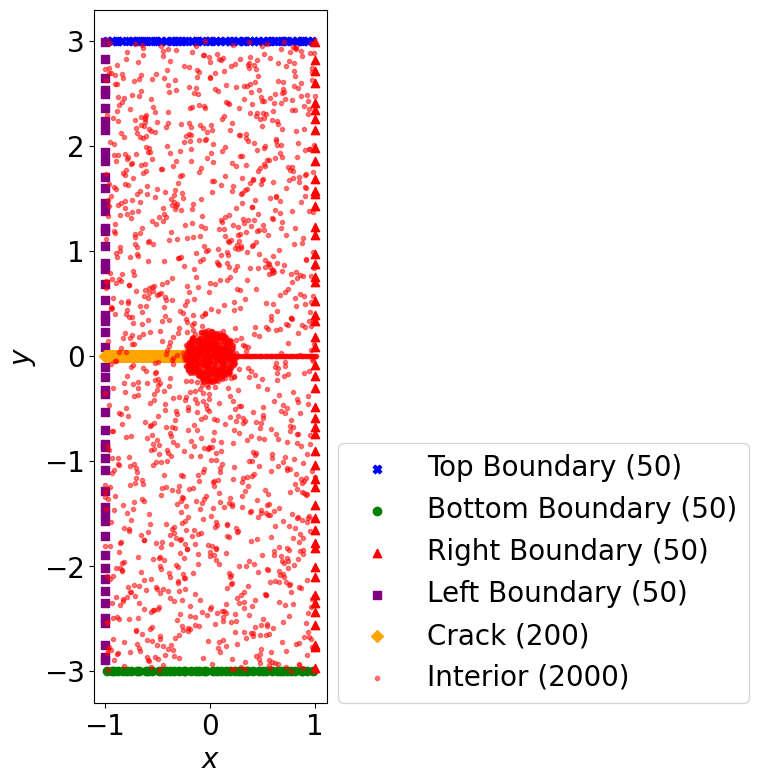

In [6]:
# Lower bounds
lb = torch.tensor([xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = torch.tensor([xmax, ymax], dtype=DTYPE)

X_b_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, \
    Sxx_crack_train, Syy_crack_train, Sxy_crack_train = getBoundary_points(xmin,xmax,ymin,ymax,DTYPE,N_bound,N_crack)
X_col_train = getCollocation_points_m(xmin,xmax,ymin,ymax,N_r,N_r_J,N_tip)


#绘制采样点
[x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train] = X_train_list
fig = plt.figure(figsize=(3,9))

# 为每组边界点指定颜色、记号和标签
boundary_data = [
    (x_up_train, 'blue', 'X', 'Top Boundary'),
    (x_lo_train, 'green', 'o', 'Bottom Boundary'),
    (x_ri_train, 'red', '^', 'Right Boundary'),
    (x_le_train, 'purple', 's', 'Left Boundary'),
    (crack_train, 'orange', 'D', 'Crack')
]
plt.rcParams.update({'font.size': 20})
# 绘制边界点
for boundary_train, color, marker, label in boundary_data:
    plt.scatter(boundary_train[:,0], boundary_train[:,1], c=color, marker=marker, label=f"{label} ({len(boundary_train)})")
# 绘制配置点
plt.scatter(X_col_train[:,0], X_col_train[:,1], c='red', marker='.', alpha=0.5, label=f"Interior ({len(X_col_train)})")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

# plt.title('Positions of collocation points and boundary data')
# 显示图例在右上角
plt.legend(loc=(1.05, 0))
# 保存图像
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)
plt.show()

### 网络设置

In [7]:
class LinearBlock(nn.Module):

    def __init__(self, in_nodes, out_nodes):
        super(LinearBlock, self).__init__()
        self.layer = nn.utils.weight_norm(nn.Linear(in_nodes, out_nodes), dim = 0)

    def forward(self, x):
        x = self.layer(x)
        x = torch.tanh(x) 
        return x

class PINN(nn.Module):

    def __init__(self, layer_list):
        super(PINN, self).__init__()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.input_layer = nn.utils.weight_norm(nn.Linear(layer_list[0], layer_list[1]), dim = 0)
        self.hidden_layers = self._make_layer(layer_list[1:-1])
        self.output_layer = nn.Linear(layer_list[-2], layer_list[-1])
        
    def _make_layer(self, layer_list):
        layers = []
        for i in range(len(layer_list) - 1):
            block = LinearBlock(layer_list[i], layer_list[i + 1])
            layers.append(block)
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.input_layer(x)
        x = torch.tanh(x) 
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        output_Ux = x[:,0][:,None]
        output_Uy = x[:,1][:,None]
        output_Sxx = x[:,2][:,None]
        output_Syy = x[:,3][:,None]
        output_Sxy = x[:,4][:,None]
        return output_Ux, output_Uy, output_Sxx, output_Syy, output_Sxy
    
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)

def pinn(layer_list):
    model = PINN(layer_list)
    model.apply(weights_init)
    return model

In [8]:
# Create the model
layers = [2] + num_hidden * [num_nodes] + [5]
model = pinn(layers)
#print(model) #打印模型结构

/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


### 损失函数

In [9]:
def fun_r_x(x, y, dsxxdx, dsxydy):
    return dsxxdx + dsxydy - f_x_ext(x, y)

def fun_r_y(x, y, dsxydx, dsyydy):
    return dsxydx + dsyydy - f_y_ext(x, y)

def fun_r_const_x(x, y, duxdx, duydy, Sxx):
    return (lmda + 2 * mu) * duxdx + lmda * duydy - Sxx

def fun_r_const_y(x, y, duxdx, duydy, Syy):
    return (lmda + 2 * mu) * duydy + lmda * duxdx - Syy

def fun_r_const_xy(x, y, duxdy, duydx, Sxy):
    return 2 * mu * 0.5 * (duxdy + duydx) - Sxy

def fun_b_r_ux(ux_up, ux_lo, ux_b_train):
    return torch.cat((ux_up, ux_lo), dim=0) - ux_b_train

def fun_b_r_uy(uy_lo,uy_ri, uy_le, uy_b_train):
    return torch.cat((uy_lo,uy_ri, uy_le), dim=0) - uy_b_train

def fun_b_r_Sxx(Sxx_ri, Sxx_le, Sxx_b_train):
    return torch.cat((Sxx_ri, Sxx_le), dim=0) - Sxx_b_train

def fun_b_r_Syy(Syy_up,Syy_lo, Syy_b_train):
    return torch.cat((Syy_up,Syy_lo), dim=0) - Syy_b_train


def fun_crack_r_Sxx(Sxx_crack, Sxx_crack_train):
    return Sxx_crack - Sxx_crack_train

def fun_crack_r_Syy(Syy_crack, Syy_crack_train):
    return Syy_crack - Syy_crack_train

def fun_crack_r_Sxy(Sxy_crack, Sxy_crack_train):
    return Sxy_crack - Sxy_crack_train

#内部点处的数值LOSS和PED_LOSS

def get_r(model, X_col_train):
    # Split x and y to compute partial derivatives
    x = X_col_train[:, 0].clone().requires_grad_(True)[:,None]
    y = X_col_train[:, 1].clone().requires_grad_(True)[:,None]

    # Determine residual
    Ux, Uy, Sxx, Syy, Sxy = model(torch.hstack([x, y]))
    ux = Ux
    uy = Uy
    sxx = Sxx
    syy = Syy
    sxy = Sxy

    # Compute gradients of ux and uy
    grads_ux = torch.autograd.grad(ux, [x, y],torch.ones_like(ux), create_graph=True)
    duxdx, duxdy = grads_ux[0], grads_ux[1]

    grads_uy = torch.autograd.grad(uy, [x, y],torch.ones_like(uy), create_graph=True)
    duydx, duydy = grads_uy[0], grads_uy[1]
    
    # Compute gradients of sxx, syy, and sxy
    grads_sxx = torch.autograd.grad(sxx, [x, y],torch.ones_like(sxx), create_graph=True)
    dsxxdx = grads_sxx[0]

    grads_syy = torch.autograd.grad(syy, [x, y],torch.ones_like(syy), create_graph=True)
    dsyydy = grads_syy[1]

    grads_sxy = torch.autograd.grad(sxy, [x, y],torch.ones_like(sxy), create_graph=True)
    dsxydx, dsxydy = grads_sxy[0], grads_sxy[1]

    return fun_r_x(x, y, dsxxdx, dsxydy), fun_r_y(x, y, dsxydx, dsyydy), \
        fun_r_const_x(x, y, duxdx, duydy, Sxx), fun_r_const_y(x, y, duxdx, duydy, Syy), \
            fun_r_const_xy(x, y, duxdy, duydx, Sxy)


#边界处的数值LOSS和PED_LOSS

def get_b_r_uS(model, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train,Sxx_crack_train, Syy_crack_train, Sxy_crack_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train = X_train_list[0], \
                    X_train_list[1], X_train_list[2], X_train_list[3], X_train_list[4]
    # Split x and y to compute partial derivatives
    x_up, y_up = x_up_train[:, 0][:,None], x_up_train[:, 1][:,None]
    x_lo, y_lo = x_lo_train[:, 0][:,None], x_lo_train[:, 1][:,None]
    x_ri, y_ri = x_ri_train[:, 0][:,None], x_ri_train[:, 1][:,None]
    x_le, y_le = x_le_train[:, 0][:,None], x_le_train[:, 1][:,None]
    ##crack boundary
    x_crack = crack_train[:, 0][:,None]
    y_crack = crack_train[:, 1][:,None]

    # Determine residual 
    Ux_up, Uy_up, Sxx_up, Syy_up, Sxy_up  = model(torch.hstack((x_up, y_up)))
    Ux_lo, Uy_lo, Sxx_lo, Syy_lo, Sxy_lo  = model(torch.hstack((x_lo, y_lo)))
    Ux_ri, Uy_ri, Sxx_ri, Syy_ri, Sxy_ri  = model(torch.hstack((x_ri, y_ri)))
    Ux_le, Uy_le, Sxx_le, Syy_le, Sxy_le  = model(torch.hstack((x_le, y_le)))
    Ux_crack, Uy_crack, Sxx_crack, Syy_crack, Sxy_crack  = model(torch.hstack((x_crack, y_crack)))
    
    ux_up, _ = Ux_up, Uy_up
    ux_lo, uy_lo = Ux_lo, Uy_lo
    _, uy_ri = Ux_ri, Uy_ri
    _, uy_le = Ux_le, Uy_le

    return fun_b_r_ux(ux_up, ux_lo, ux_b_train), fun_b_r_uy(uy_lo,uy_ri, uy_le, uy_b_train),\
        fun_b_r_Sxx(Sxx_ri, Sxx_le, Sxx_b_train), fun_b_r_Syy(Syy_up,Syy_lo, Syy_b_train),\
            fun_crack_r_Sxx(Sxx_crack, Sxx_crack_train),fun_crack_r_Syy(Syy_crack, Syy_crack_train),\
                fun_crack_r_Sxy(Sxy_crack, Sxy_crack_train)



def compute_loss(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train,Sxx_crack_train, Syy_crack_train, Sxy_crack_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train = X_train_list[0], \
                    X_train_list[1], X_train_list[2], X_train_list[3], X_train_list[4]

    # Compute phi^r use absolute error
    rx, ry, rx_const, ry_const, rxy_const= get_r(model, X_col_train)
    phi_r = torch.mean(torch.abs(rx)**2) + torch.mean(torch.abs(ry)**2)
    phi_r_const = torch.mean(torch.abs(rx_const)**2) + torch.mean(torch.abs(ry_const)**2) + torch.mean(torch.abs(rxy_const)**2)

    # Compute phi^b
    r_ux, r_uy, r_Sxx, r_Syy, rc_Sxx, rc_Syy,rc_Sxy  = get_b_r_uS(model, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train,Sxx_crack_train, Syy_crack_train, Sxy_crack_train)
    phi_r_u = torch.mean(torch.abs(r_ux)**2) + torch.mean(torch.abs(r_uy)**2)
    phi_r_S = torch.mean(torch.abs(r_Sxx)**2) + torch.mean(torch.abs(r_Syy)**2)+ torch.mean(torch.abs(rc_Sxx)**2)\
    + torch.mean(torch.abs(rc_Syy)**2)+ torch.mean(torch.abs(rc_Sxy)**2)
    
    loss = phi_r + phi_r_const + phi_r_u + phi_r_S
    return loss

def get_grad(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Sxx_crack_train, Syy_crack_train, Sxy_crack_train):
    # Set requires_grad=True for trainable parameters
    for param in model.parameters():
        param.requires_grad = True

    # Forward pass and compute loss
    loss = compute_loss(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Sxx_crack_train, Syy_crack_train, Sxy_crack_train)

    # Backward pass
    loss.backward()

    # Get gradients
    g = [param.grad.clone() for param in model.parameters()]

    return loss, g

## 训练模型

In [30]:
# Choose the optimizer  优化器选择，Adam利用梯度的一阶矩估计和二阶矩估计动态调整每个参数的学习率。
# 它的优点主要在于经过偏置校正后，每一次迭代学习率都有个确定范围，使得参数比较平稳。
lr = 1e-3 #学习率，更新梯度的时候使用

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer=optimizer, milestones=[num_epochs/20, num_epochs/10], gamma=0.1)

# Number of training epochs
hist = []

# Define a training step
def train_step():
    #model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients

    # Compute current loss
    loss, grad_theta = get_grad(model, X_col_train, X_train_list, ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Sxx_crack_train, Syy_crack_train, Sxy_crack_train)
        # Perform gradient descent step
    for i, param in enumerate(model.parameters()):
        param.grad = grad_theta[i]

    optimizer.step()

    return loss.item()

# Start timer
t0 = time()

for i in tqdm(range(num_epochs+1)):
    loss = train_step()

    if i == 0:
        loss0 = loss
    hist.append(loss / loss0)
    
    if hist[-1] <= 1e-12:
        print('Loss threshold reached. Stopping training.')
        break

    # Output current loss after 50 iterates
    if i % 1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time() - t0))


  0%|          | 6/10001 [00:00<06:18, 26.38it/s]

It 00000: loss = 1.07651224e+02


 10%|█         | 1005/10001 [00:35<05:05, 29.47it/s]

It 01000: loss = 6.54288375e+00


 20%|██        | 2004/10001 [01:09<04:44, 28.10it/s]

It 02000: loss = 4.70679636e+00


 30%|███       | 3005/10001 [01:44<04:06, 28.43it/s]

It 03000: loss = 8.73295959e+00


 40%|████      | 4006/10001 [02:19<03:42, 26.90it/s]

It 04000: loss = 5.90008195e+00


 50%|█████     | 5004/10001 [02:54<02:51, 29.09it/s]

It 05000: loss = 6.92649656e+00


 60%|██████    | 6005/10001 [03:29<02:21, 28.34it/s]

It 06000: loss = 3.80470065e+00


 70%|███████   | 7005/10001 [04:05<01:52, 26.58it/s]

It 07000: loss = 2.25943962e+00


 80%|████████  | 8006/10001 [04:41<01:15, 26.48it/s]

It 08000: loss = 6.71467260e+00


 90%|█████████ | 9004/10001 [05:18<00:36, 27.53it/s]

It 09000: loss = 7.38803722e+00


100%|██████████| 10001/10001 [05:53<00:00, 28.29it/s]

It 10000: loss = 1.32309636e+01

Computation time: 353.49012780189514 seconds


In [31]:
# 选择不同的优化方法LBFGS
opt_LBFGS = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20)
# 不同方法的loss
loss_LBFGS = []

# Define a training step
def train_LBFGS_step():
    opt_LBFGS.zero_grad()

    # Define the closure function
    def closure():
        opt_LBFGS.zero_grad()
        loss, grad_theta = get_grad(model, X_col_train, X_train_list,
                                     ux_b_train, uy_b_train,
                                       Sxx_b_train, Syy_b_train,
                                         Sxx_crack_train, Syy_crack_train, Sxy_crack_train)
        for i, param in enumerate(model.parameters()):
            param.grad = grad_theta[i]
        return loss

    # Perform the optimization step
    loss = opt_LBFGS.step(closure)

    # Extract the loss and other values from the closure
    loss, grad_theta = get_grad(model, X_col_train, X_train_list,
                                     ux_b_train, uy_b_train,
                                       Sxx_b_train, Syy_b_train,
                                         Sxx_crack_train, Syy_crack_train, Sxy_crack_train)
    return loss.item()

# Start timer
t0 = time()

for i in tqdm(range(N_l+1)):
    loss  = train_LBFGS_step()

    #将状态加载到优化器
    #optimizer.load_state_dict(optimizer_state)

    loss_LBFGS.append(loss / loss0)

    if loss_LBFGS[-1] <= 1e-10:
        print('Loss threshold reached. Stopping training.')
        break

    # Output current loss after 50 iterates
    if i % 100 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time() - t0))

  0%|          | 1/1001 [00:00<12:30,  1.33it/s]

It 00000: loss = 1.31398105e+01


 10%|█         | 101/1001 [01:25<13:01,  1.15it/s]

It 00100: loss = 4.43982232e+00


 20%|██        | 201/1001 [02:51<11:21,  1.17it/s]

It 00200: loss = 2.78631867e+00


 30%|███       | 301/1001 [04:16<09:51,  1.18it/s]

It 00300: loss = 1.16722297e+00


 40%|████      | 401/1001 [05:42<08:25,  1.19it/s]

It 00400: loss = 5.63645778e-01


 50%|█████     | 501/1001 [07:06<07:04,  1.18it/s]

It 00500: loss = 3.51457470e-01


 60%|██████    | 601/1001 [08:32<05:40,  1.18it/s]

It 00600: loss = 2.47537734e-01


 70%|███████   | 701/1001 [09:58<04:20,  1.15it/s]

It 00700: loss = 2.10635692e-01


 80%|████████  | 801/1001 [11:25<02:48,  1.19it/s]

It 00800: loss = 1.81063631e-01


 90%|█████████ | 901/1001 [12:53<01:30,  1.11it/s]

It 00900: loss = 1.57552548e-01


100%|██████████| 1001/1001 [14:21<00:00,  1.16it/s]

It 01000: loss = 1.16343108e-01

Computation time: 861.7461998462677 seconds


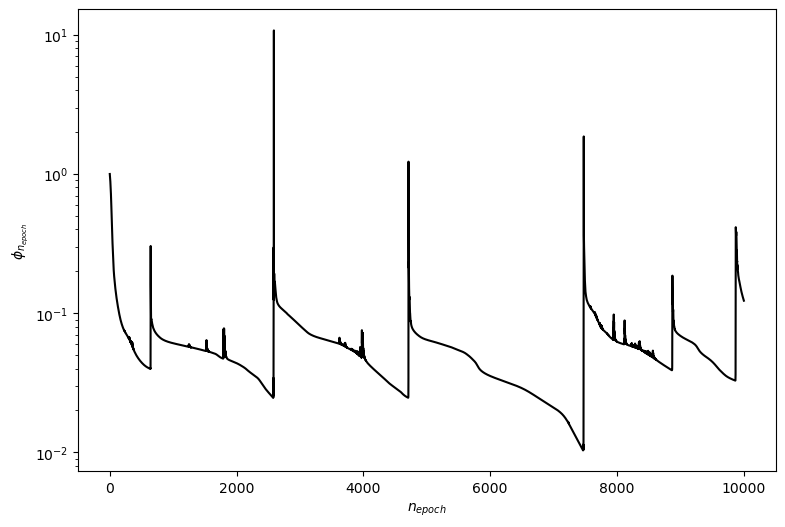

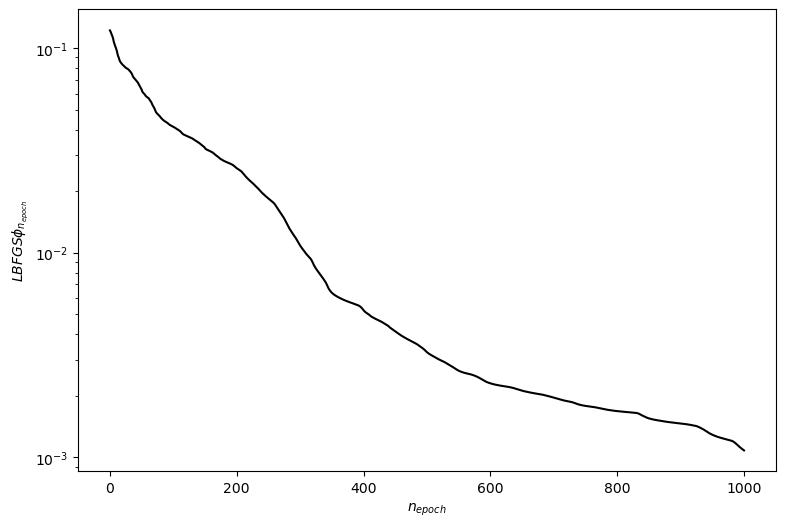

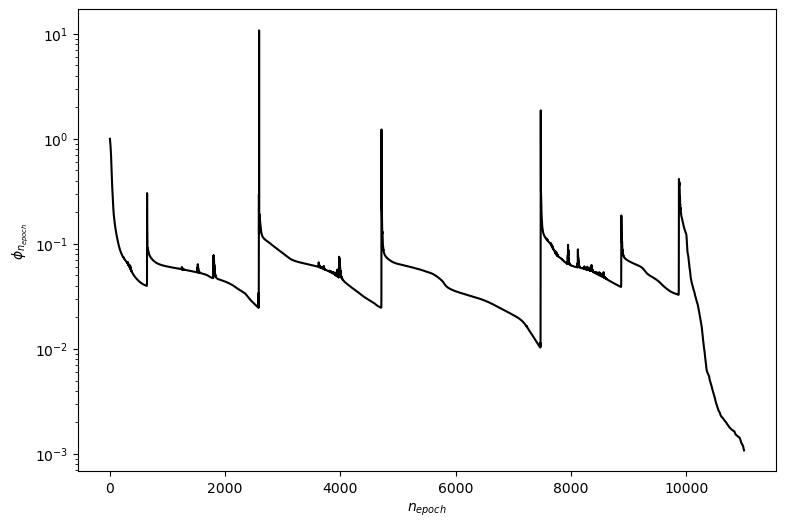

In [32]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel(r'$\phi_{n_{epoch}}$')
plt.show()

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(loss_LBFGS)), loss_LBFGS,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel(r'$LBFGS\phi_{n_{epoch}}$')
plt.show()


hist_Adma_LB = np.concatenate((hist, loss_LBFGS))
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist_Adma_LB)), hist_Adma_LB,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel(r'$\phi_{n_{epoch}}$')
plt.show()

### 保存整个模型


In [33]:
torch.save(model, 'model_pinns.pth')

import pickle

data = {
    'hist': hist,
    'hist_loss_LBFGS': loss_LBFGS,
}

with open('training_hist_pinns.pkl', 'wb') as f:
    pickle.dump(data, f)

## 结果及分析

In [10]:
import pickle
modelMNN = torch.load('model_pinns.pth', weights_only=False)

with open('training_hist_pinns.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
hist = loaded_data['hist']
loss_LBFGS = loaded_data['hist_loss_LBFGS']

In [11]:
# Set up meshgrid
N = 600
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)
X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T

# Determine predictions of u(t, x)
Ux_pred, Uy_pred, Sxx_pred, Syy_pred, Sxy_pred = model(torch.Tensor(Xgrid))

ux_pred = Ux_pred
uy_pred = Uy_pred 

# Reshape upred
Ux = ux_pred.detach().numpy().reshape(N+1,N+1)
Uy = uy_pred.detach().numpy().reshape(N+1,N+1)
Uhat = np.sqrt(Ux*Ux+Uy*Uy)

#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

# calculate exact solutions
ux_ext = u_x_ext(X.flatten(),Y.flatten())
uy_ext = u_y_ext(X.flatten(),Y.flatten())

# Reshape upred
Ux_ext = ux_ext.detach().numpy().reshape(N+1,N+1)
Uy_ext = uy_ext.detach().numpy().reshape(N+1,N+1)
Uhat_ext = np.sqrt(Ux_ext*Ux_ext+Uy_ext*Uy_ext)

# Determine predictions of u(t, x)
sxx_pred = Sxx_pred
syy_pred = Syy_pred
sxy_pred = Sxy_pred

# Reshape upred
Sxx = sxx_pred.detach().numpy().reshape(N+1,N+1)
Syy = syy_pred.detach().numpy().reshape(N+1,N+1)
Sxy = sxy_pred.detach().numpy().reshape(N+1,N+1)

sxx_ext = Sigmaxx_ext(X.flatten(),Y.flatten())
syy_ext = Sigmayy_ext(X.flatten(),Y.flatten())
sxy_ext = Sigmaxy_ext(X.flatten(),Y.flatten())

Sxx_ext = sxx_ext.detach().numpy().reshape(N+1,N+1)
Syy_ext = syy_ext.detach().numpy().reshape(N+1,N+1)
Sxy_ext = sxy_ext.detach().numpy().reshape(N+1,N+1)

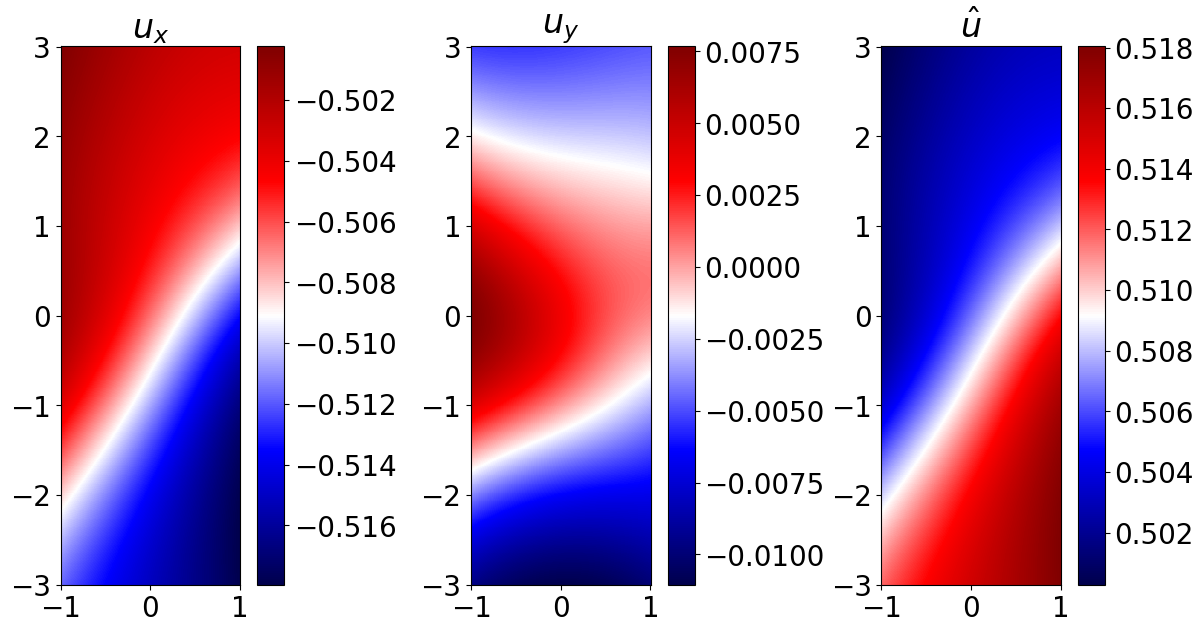

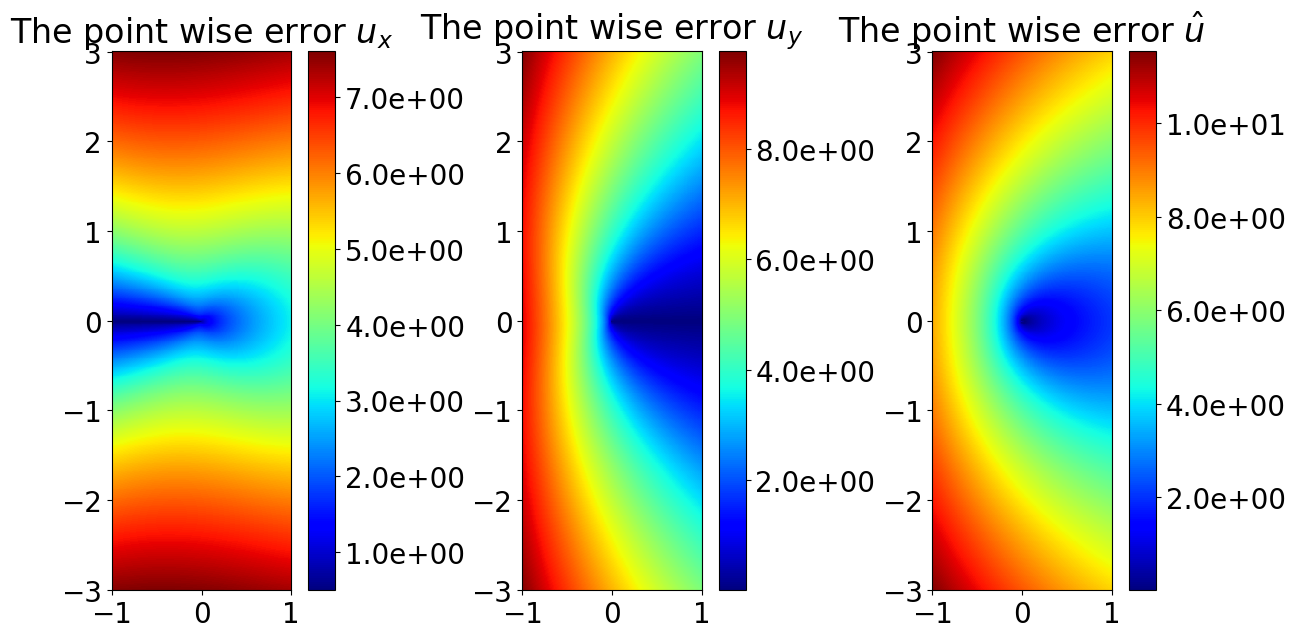

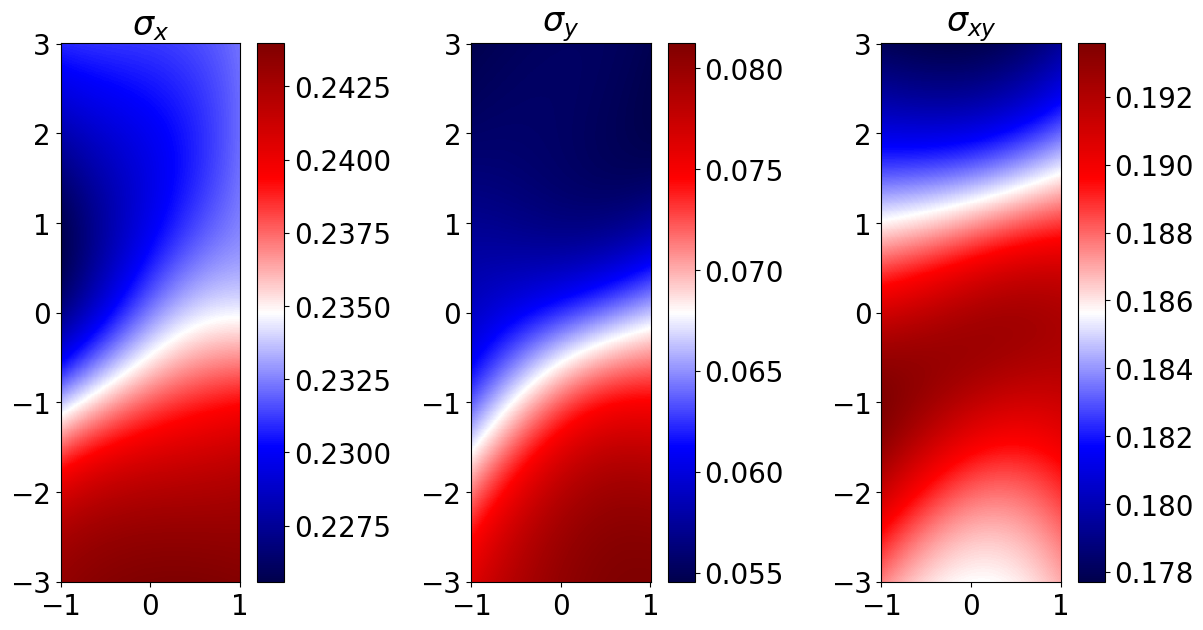

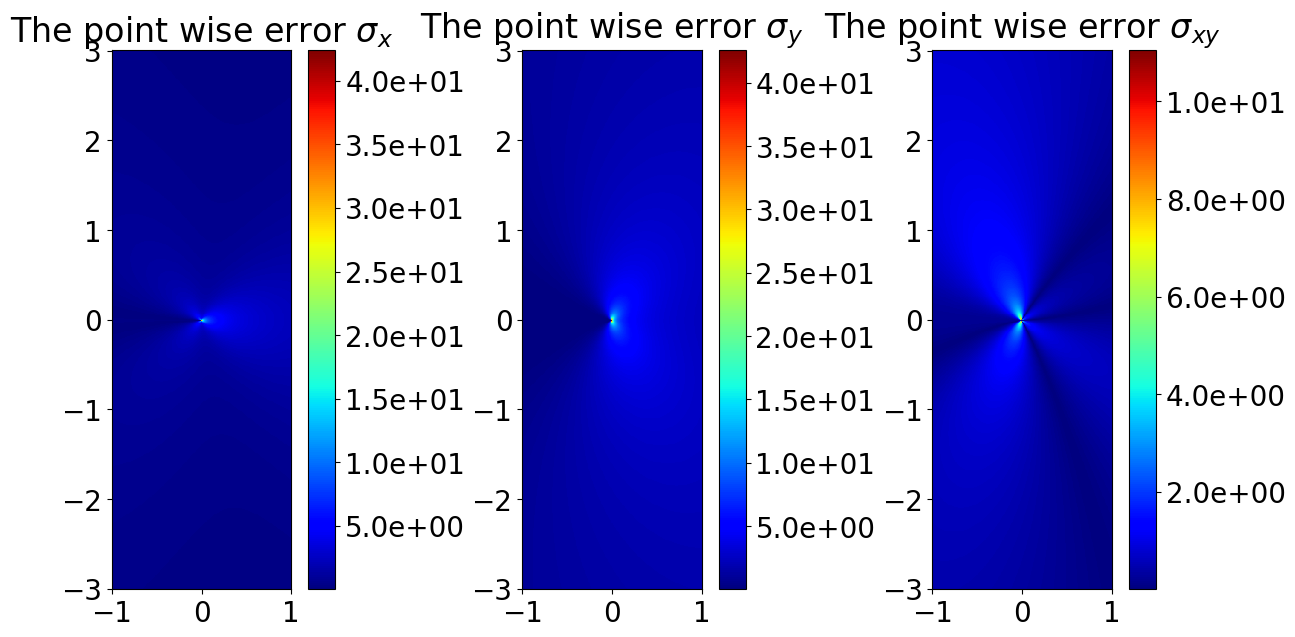

In [12]:
import matplotlib.ticker as ticker
U_total = [Ux, Uy, Uhat]
U_total_name = [r'${u_x}$', r'${u_y}$', r'${\hat{u}}$']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, U_total[i], cmap='seismic')
    ax.set_title(U_total_name[i])
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)
plt.show()

error_total = [abs(Ux-Ux_ext), abs(Uy-Uy_ext), abs(Uhat-Uhat_ext)]
error_total_name = [
    r'The point wise error $u_x$', 
    r'The point wise error $u_y$', 
    r'The point wise error $\hat{u}$'
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, error_total[i], cmap='jet')
    ax.set_title(error_total_name[i])
    ax.set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax)
    cbar.formatter = ticker.ScalarFormatter(useMathText=True)
    cbar.formatter.set_scientific(True)  # 使用科学记数法
    cbar.formatter = ticker.FormatStrFormatter('%.1e')  # 设置科学记数法并保留两位有效数字
    cbar.ax.yaxis.get_offset_text().set_visible(False)  # 隐藏偏移文本
plt.show()

S_total = [Sxx, Syy, Sxy]
S_total_name = [
    r'$\sigma_{x}$', 
    r'$\sigma_{y}$', 
    r'$\sigma_{xy}$'
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, S_total[i], cmap='seismic')
    ax.set_title(S_total_name[i])
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)
plt.show()

S_total = [abs(Sxx_ext-Sxx), abs(Syy_ext-Syy), abs(Sxy_ext-Sxy)]
S_total_name = [
    r'The point wise error $\sigma_{x}$', 
    r'The point wise error $\sigma_{y}$', 
    r'The point wise error $\sigma_{xy}$'
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
for i,ax in enumerate(axes.flat):
    im = ax.pcolor(X, Y, S_total[i], cmap='jet')
    ax.set_title(S_total_name[i])
    ax.set_aspect('equal')
    cbar = fig.colorbar(im, ax=ax)
    cbar.formatter = ticker.ScalarFormatter(useMathText=True)
    cbar.formatter.set_scientific(True)  # 使用科学记数法
    cbar.formatter = ticker.FormatStrFormatter('%.1e')  # 设置科学记数法并保留两位有效数字
    cbar.ax.yaxis.get_offset_text().set_visible(False)  # 隐藏偏移文本
plt.show()

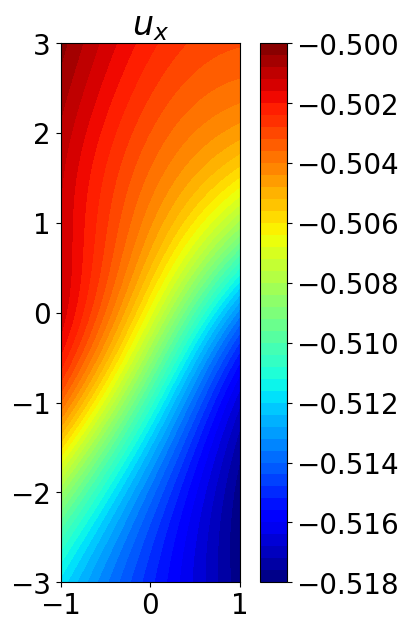

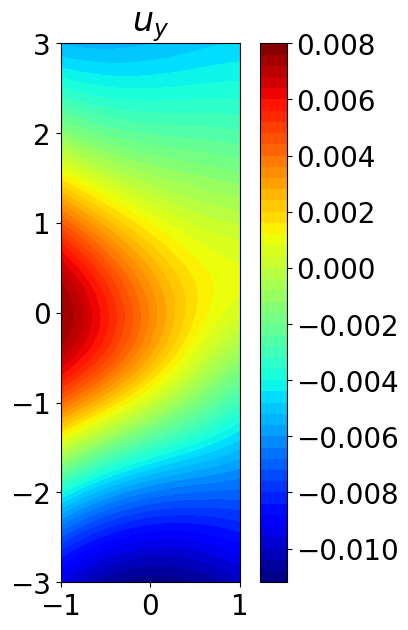

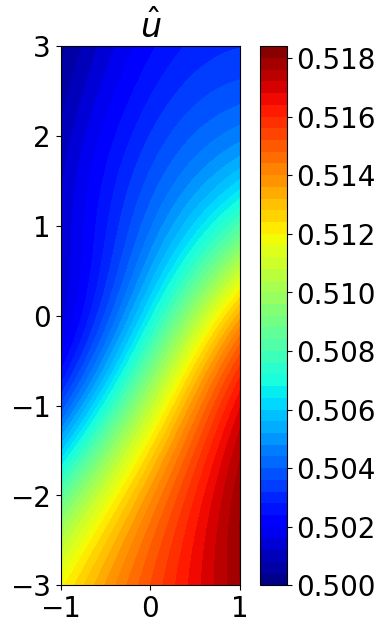

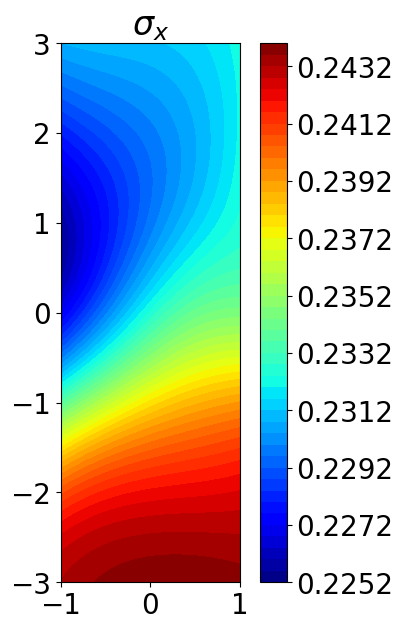

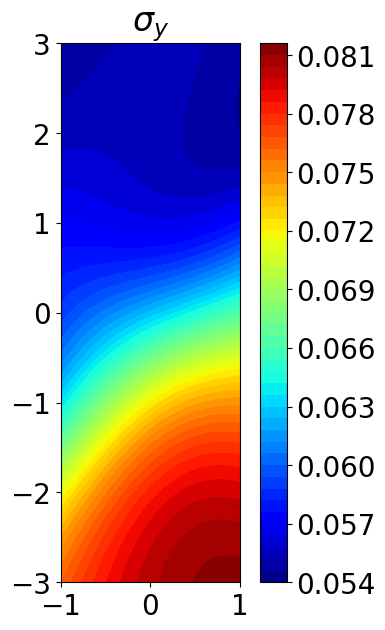

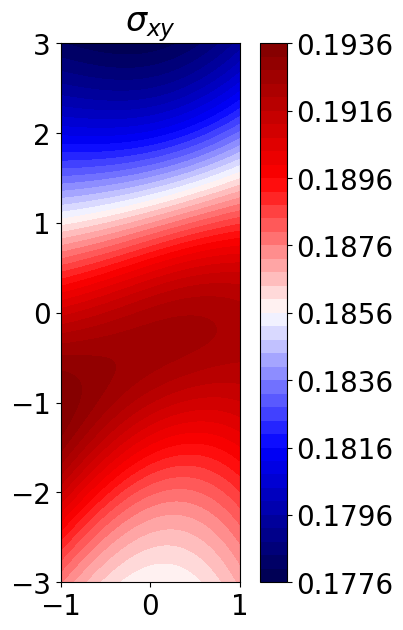

In [16]:
# 第一幅图
fig1, ax1 = plt.subplots(figsize=(5, 7))  # 调整每幅图的大小
im1 = ax1.contourf(X, Y, U_total[0], levels=50, cmap='jet')
ax1.set_title(U_total_name[0])
ax1.set_aspect('equal')
fig1.colorbar(im1, ax=ax1)
plt.show()

# 第二幅图
fig2, ax2 = plt.subplots(figsize=(5, 7))
im2 = ax2.contourf(X, Y, U_total[1], levels=50, cmap='jet')
ax2.set_title(U_total_name[1])
ax2.set_aspect('equal')
fig2.colorbar(im2, ax=ax2)
plt.show()

# 第三幅图
fig3, ax3 = plt.subplots(figsize=(5, 7))
im3 = ax3.contourf(X, Y, U_total[2], levels=50, cmap='jet')
ax3.set_title(U_total_name[2])
ax3.set_aspect('equal')
fig3.colorbar(im3, ax=ax3)
plt.show()

colormaps = ['jet', 'jet', 'seismic']

# 第一幅图
fig1, ax1 = plt.subplots(figsize=(5, 7))
im1 = ax1.contourf(X, Y, S_total[0], levels=50, cmap=colormaps[0])
ax1.set_title(S_total_name[0])
ax1.set_aspect('equal')
fig1.colorbar(im1, ax=ax1)
plt.show()

# 第二幅图
fig2, ax2 = plt.subplots(figsize=(5, 7))
im2 = ax2.contourf(X, Y, S_total[1], levels=50, cmap=colormaps[1])
ax2.set_title(S_total_name[1])
ax2.set_aspect('equal')
fig2.colorbar(im2, ax=ax2)
plt.show()

# 第三幅图
fig3, ax3 = plt.subplots(figsize=(5, 7))
im3 = ax3.contourf(X, Y, S_total[2], levels=50, cmap=colormaps[2])
ax3.set_title(S_total_name[2])
ax3.set_aspect('equal')
fig3.colorbar(im3, ax=ax3)
plt.show()

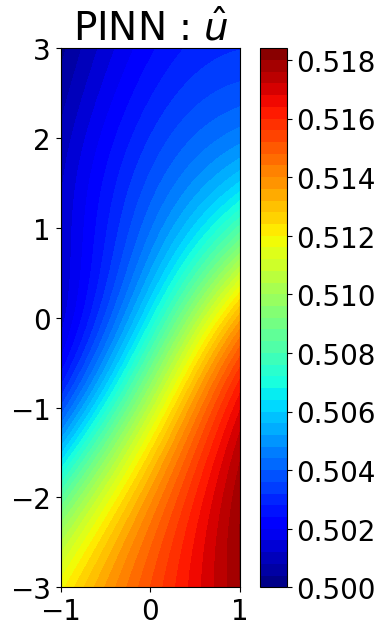

In [13]:
# 第三幅图
fig3, ax3 = plt.subplots(figsize=(5, 7))
im3 = ax3.contourf(X, Y, U_total[2], levels=50, cmap='jet')
ax3.set_title(r'PINN : ${\hat{u}}$', fontsize = 28)
ax3.set_aspect('equal')
fig3.colorbar(im3, ax=ax3)
plt.show()

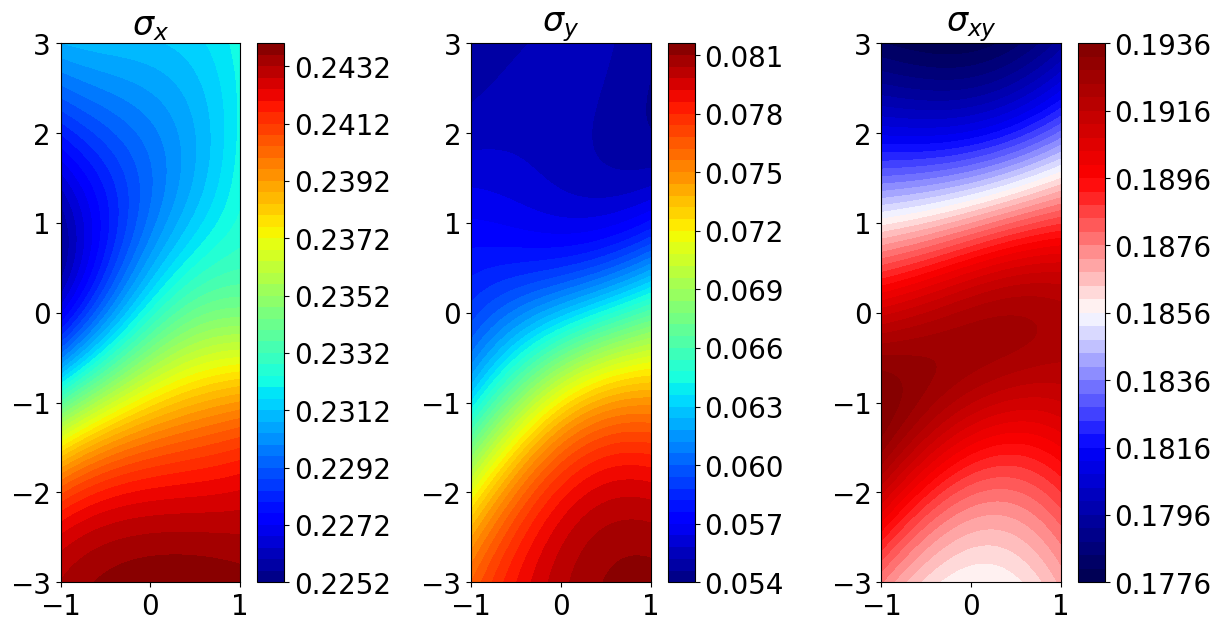

In [14]:
from matplotlib.ticker import ScalarFormatter
S_total = [Sxx, Syy, Sxy]
S_total_name = [
    r'$\sigma_{x}$', 
    r'$\sigma_{y}$', 
    r'$\sigma_{xy}$'
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

colormaps = ['jet', 'jet', 'seismic']

for i, ax in enumerate(axes.flat):
    # 使用 contourf 绘制填充等高线图，并增加等高线数量
    im = ax.contourf(X, Y, S_total[i], levels=50, cmap=colormaps[i])  # 指定不同的colormap
    ax.set_title(S_total_name[i])
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)

# 增加图像分辨率
#fig.savefig('enhanced_image.png', dpi=600)  # 保存图像时增加dpi参数

plt.show()

In [39]:

errorux_1 = np.linalg.norm(Ux-Ux_ext, 2) / np.linalg.norm(Ux_ext,2)
erroruy_1 = np.linalg.norm(Uy-Uy_ext, 2) / np.linalg.norm(Uy_ext,2)
erroruh_1 = np.linalg.norm(Uhat - Uhat_ext, 2) / np.linalg.norm(Uhat_ext,2)
print('Error2 Ux: %e' % (errorux_1))
print('Error2 Uy: %e' % (erroruy_1))
print('Error2 Uhat: %e' % (erroruh_1))


Error2 Ux: 4.852765e-01
Error2 Uy: 2.726260e-01
Error2 Uhat: 2.852295e-01


In [40]:
if np.any(np.isinf(Sxx)) or np.any(np.isnan(Sxx)):
    #raise ValueError("Matrix Sxx contains inf or NaN values.")
    Sxx = np.nan_to_num(Sxx, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Sxx_ext)) or np.any(np.isnan(Sxx_ext)):
    #raise ValueError("Matrix Sxx_ext contains inf or NaN values.")
    Sxx_ext = np.nan_to_num(Sxx_ext, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Syy)) or np.any(np.isnan(Syy)):
    #raise ValueError("Matrix Sxx contains inf or NaN values.")
    Syy = np.nan_to_num(Syy, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Syy_ext)) or np.any(np.isnan(Syy_ext)):
    #raise ValueError("Matrix Sxx_ext contains inf or NaN values.")
    Syy_ext = np.nan_to_num(Syy_ext, nan=0.0, posinf=0.0, neginf=0.0)

if np.any(np.isinf(Sxy)) or np.any(np.isnan(Sxy)):
    #raise ValueError("Matrix Sxx contains inf or NaN values.")
    Sxy = np.nan_to_num(Sxy, nan=0.0, posinf=0.0, neginf=0.0)

if np.any(np.isinf(Sxy_ext)) or np.any(np.isnan(Sxy_ext)):
    #raise ValueError("Matrix Sxx_ext contains inf or NaN values.")
    Sxy_ext = np.nan_to_num(Sxy_ext, nan=0.0, posinf=0.0, neginf=0.0)

In [41]:
errorSxx_1 = np.linalg.norm(Sxx-Sxx_ext, 2) / np.linalg.norm(Sxx_ext,2)
errorSyy_1 = np.linalg.norm(Syy-Syy_ext, 2) / np.linalg.norm(Syy_ext,2)
errorSxy_1 = np.linalg.norm(Sxy - Sxy_ext, 2) / np.linalg.norm(Sxy_ext,2)
print('Error2 Sxx: %e' % (errorSxx_1))
print('Error2 Syy: %e' % (errorSyy_1))
print('Error2 Sxy: %e' % (errorSxy_1))

Error2 Sxx: 5.106189e-01
Error2 Syy: 6.163192e-01
Error2 Sxy: 1.187682e+00


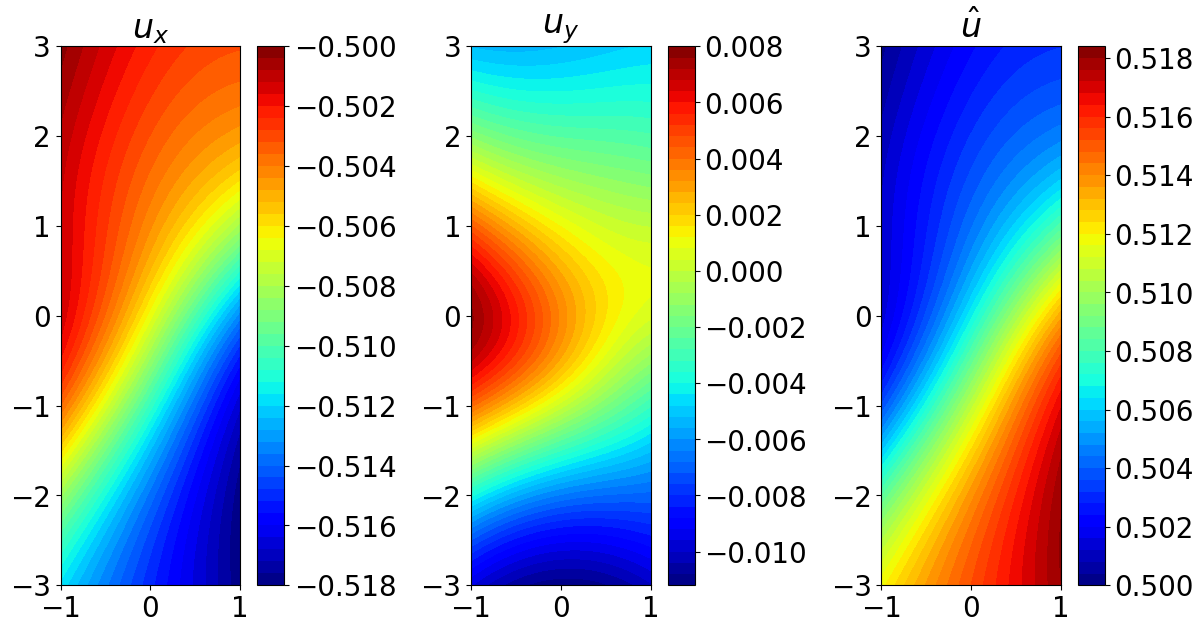

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
colormaps = ['jet', 'jet', 'jet']
for i,ax in enumerate(axes.flat):
    im = ax.contourf(X, Y, U_total[i], levels=50, cmap=colormaps[i])
    ax.set_title(U_total_name[i])
    ax.set_aspect('equal')
    fig.colorbar(im, ax=ax)
plt.show()

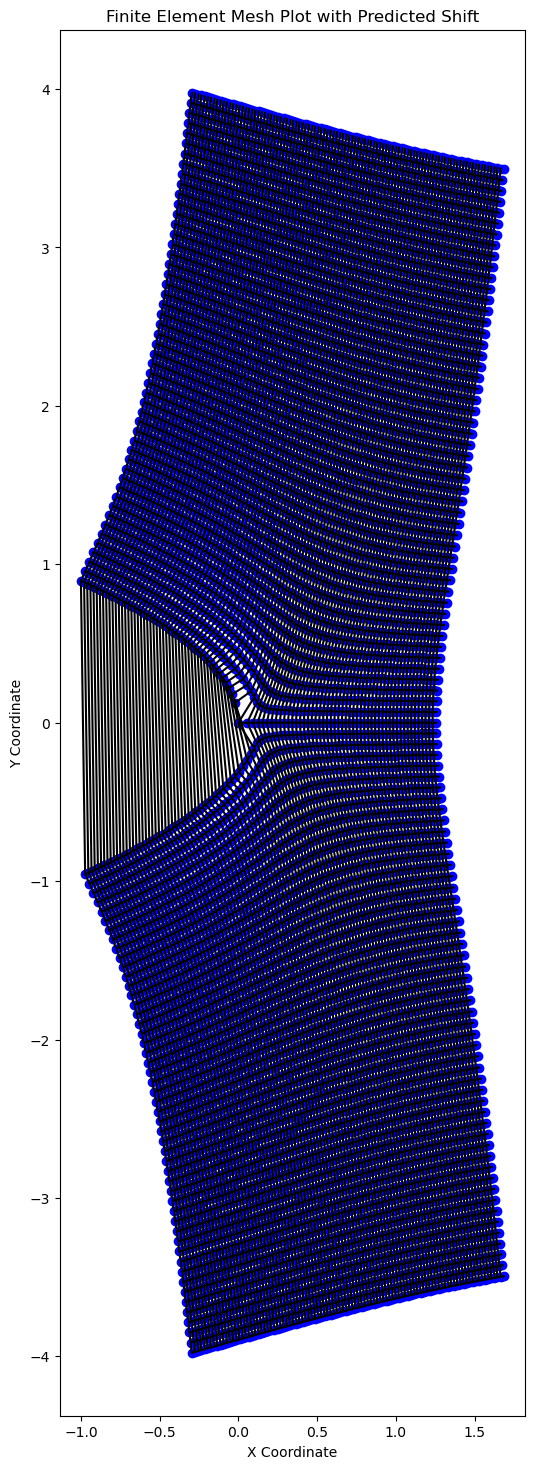

In [43]:
# Set up meshgrid
N = 100
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)

X, Y = np.meshgrid(xspace, yspace)

# calculate exact solutions
ux_ext = u_x_ext(X.flatten(),Y.flatten())
uy_ext = u_y_ext(X.flatten(),Y.flatten())


# Reshape upred
Ux_ext = ux_ext.detach().numpy().reshape(N+1,N+1)
Uy_ext = uy_ext.detach().numpy().reshape(N+1,N+1)

# 将位移应用到网格点
X += Ux_ext*1e-1
Y += Uy_ext*1e-1

# 绘制网格线
plt.figure(figsize=(6, 18))
for i in range(N):
    plt.plot(X[i, :], Y[i, :], 'k-')  # 垂直线
    plt.plot(X[:, i], Y[:, i], 'k-')  # 水平线

# 绘制网格点
plt.scatter(X.flatten(), Y.flatten(), color='blue')

# 设置图表的标题和标签
plt.title('Finite Element Mesh Plot with Predicted Shift')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# 显示图表
plt.show()

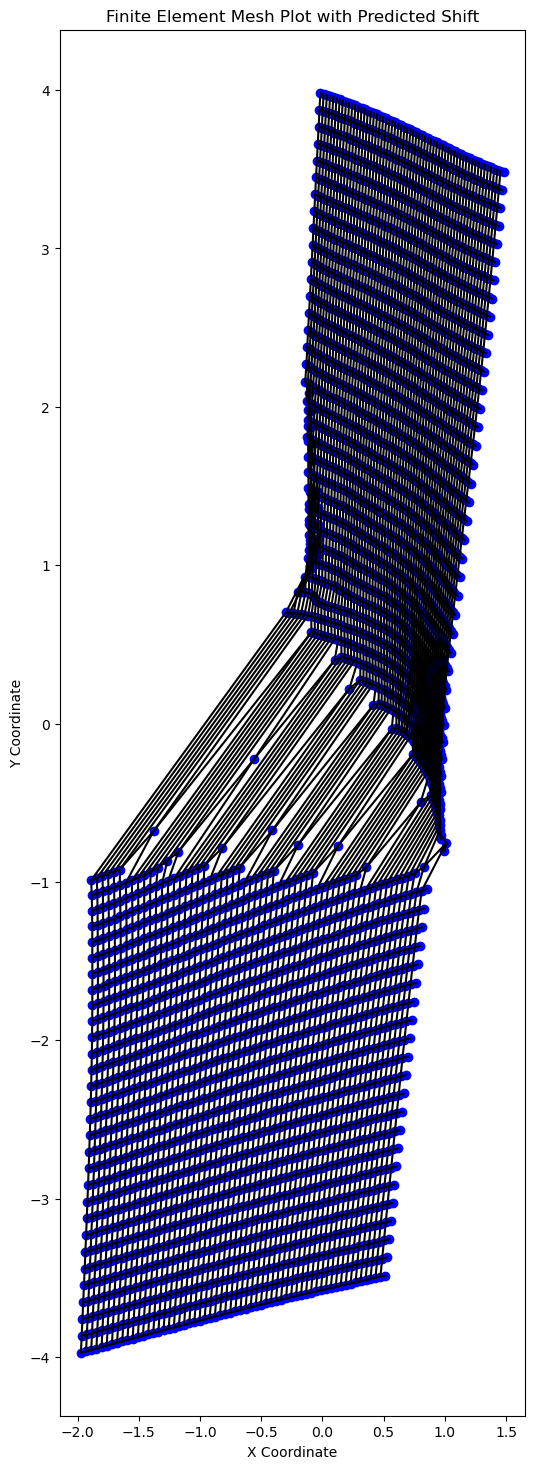

In [44]:
# Set up meshgrid
N = 60
xspace = np.linspace(lb[0], ub[0], N + 1)
yspace = np.linspace(lb[1], ub[1], N + 1)

X, Y = np.meshgrid(xspace, yspace)
Xgrid = np.vstack([X.flatten(),Y.flatten()]).T
Xgrid_tensor = torch.tensor(Xgrid, dtype=DTYPE)

Ux_pred, Uy_pred, Sxx_pred, Syy_pred, Sxy_pred = model(torch.hstack([Xgrid_tensor[:, 0].unsqueeze(1), Xgrid_tensor[:, 1].unsqueeze(1)]))

# Reshape upred
Ux_pred = Ux_pred.detach().numpy().reshape(N+1,N+1)
Uy_pred = Uy_pred.detach().numpy().reshape(N+1,N+1)

# 将位移应用到网格点
X += Uy_pred*1e-1
Y += Uy_pred*1e-1

# 绘制网格线
plt.figure(figsize=(6, 18))
for i in range(N):
    plt.plot(X[i, :], Y[i, :], 'k-')  # 垂直线
    plt.plot(X[:, i], Y[:, i], 'k-')  # 水平线

# 绘制网格点
plt.scatter(X.flatten(), Y.flatten(), color='blue')

# 设置图表的标题和标签
plt.title('Finite Element Mesh Plot with Predicted Shift')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# 显示图表
plt.show()